---
## Load packages and libraries
---

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
from underthesea import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report

from sentiment_analysis.preprocessing import processtext

---
## Load model Word2Vec and Data
---

In [ ]:
from w2v import newsWord2Vec

w2v_skipgram = newsWord2Vec()
w2v_skipgram.load("vec_models/skipgram_model.bin")

In [ ]:
df_train = pd.read_csv("sentiment_analysis/Train.csv")
X_train = df_train["content"]
y_train = df_train["label"]

df_dev = pd.read_csv("sentiment_analysis/Dev.csv")
X_dev = df_dev["content"]
y_dev = df_dev["label"]

df_test = pd.read_csv("sentiment_analysis/Test.csv")
X_test = df_test["content"]
y_test = df_test["label"]

In [ ]:
corpus_df = pd.read_csv("data/stock_full.csv")
corpus_df = corpus_df.dropna()
corpus_df = corpus_df.reset_index(drop=True)
X = corpus_df["content"]
y = corpus_df["label"]

---
## Sentiment
---

### Processing and Transform Data

In [ ]:
count = 0
def tokenize_review_sentence(sentence):
    return processtext(sentence)

X_tokenized = []
for x in X:
    X_tokenized.append(tokenize_review_sentence(x))

(array([178., 603., 640., 476., 322., 170.,  75.,  31.,  13.,  10.]),
 array([ 0. ,  4.1,  8.2, 12.3, 16.4, 20.5, 24.6, 28.7, 32.8, 36.9, 41. ]),
 <BarContainer object of 10 artists>)

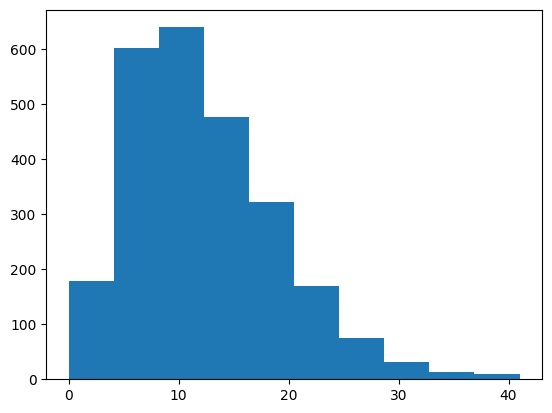

In [ ]:
sequence_lengths = []

for i in range(len(X_tokenized)):
  sequence_lengths.append(len(X_tokenized[i]))

import matplotlib.pyplot as plt

plt.hist(sequence_lengths)

In [ ]:
class Sequencer:
    def __init__(self, all_words, max_words, seq_len, embedding_matrix ):
        self.seq_len = seq_len
        self.embed_matrix = embedding_matrix
        temp_vocab = list(set(all_words))
        self.vocab = []
        self.word_cnts = {}
        for word in temp_vocab:
            count = len([0 for w in all_words if w == word])
            self.word_cnts[word] = count
            counts = list(self.word_cnts.values())
            indexes = list(range(len(counts)))

        count = 0
        while count + 1 != len(counts):
            count = 0
            for i in range(len(counts)-1):
                if counts[i] < counts[i+1]:
                    counts[i+1],counts[i] = counts[i],counts[i+1]
                    indexes[i],indexes[i+1] = indexes[i+1],indexes[i]
                else:
                    count += 1

        for ind in indexes[:max_words]:
            self.vocab.append(temp_vocab[ind])

    def textToVector(self,text):
        tokens = tokenize_review_sentence(text)
        len_v = len(tokens)-1 if len(tokens) < self.seq_len else self.seq_len-1
        vec = []
        for token in tokens[:len_v]:
            try:
                vec.append(self.embed_matrix.get_vector(token))
            except Exception as E:
                pass

        last_pieces = self.seq_len - len(vec)
        for i in range(last_pieces):
            vec.append(np.zeros(200,))

        return np.asarray(vec).flatten()

In [ ]:
sequencer = Sequencer(all_words = [token for seq in X_tokenized for token in seq],
              max_words = 792,
              seq_len = 20,
              embedding_matrix = w2v_skipgram
             )

In [ ]:
X_train_vector = [sequencer.textToVector(x) for x in X_train]

### MaxEnt (Ridge Regression)

In [ ]:
ridge_classifier = RidgeClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid for grid search
param_grid = {'alpha':  np.arange(0.1, 1.1, 0.1)}

# Perform grid search
grid_search = GridSearchCV(ridge_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vector, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'alpha': 0.8}


In [ ]:
ridge_classifier = RidgeClassifier(alpha=0.8)
ridge_classifier.fit(X_train_vector, y_train)

RidgeClassifier(alpha=0.8)

In [ ]:
X_test_vector = [sequencer.textToVector(x) for x in X_test]
ridge_predictions = ridge_classifier.predict(X_test_vector)

print("Confusion Matrix:")
print(confusion_matrix(y_test, ridge_predictions))

ridge_accuracy = accuracy_score(y_test, ridge_predictions)
ridge_precision = precision_score(y_test, ridge_predictions, average="weighted")
ridge_recall = recall_score(y_test, ridge_predictions, average="weighted")
ridge_f1 = f1_score(y_test, ridge_predictions, average="weighted")

print("Accuracy: ", ridge_accuracy)
print("Precision: ", ridge_precision)
print("Recall: ", ridge_recall)
print("F1-Score: ", ridge_f1)

Confusion Matrix:
[[55 18 13]
 [19 35 17]
 [15 17 63]]
Accuracy:  0.6071428571428571
Precision:  0.6071464528786021
Recall:  0.6071428571428571
F1-Score:  0.6070459625930751


In [ ]:
lr_result = classification_report(y_test, ridge_predictions)
print(lr_result)

              precision    recall  f1-score   support

           0       0.62      0.64      0.63        86
           1       0.50      0.49      0.50        71
           2       0.68      0.66      0.67        95

    accuracy                           0.61       252
   macro avg       0.60      0.60      0.60       252
weighted avg       0.61      0.61      0.61       252



<Axes: >

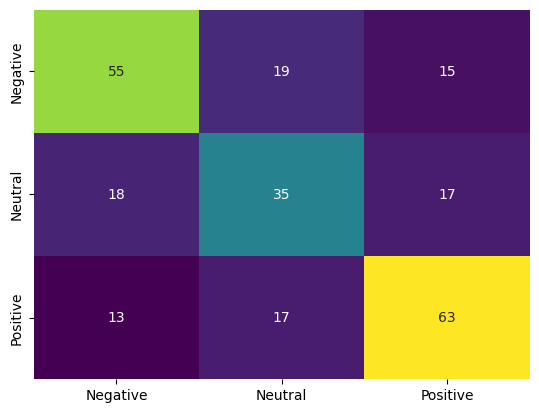

In [ ]:
lr_conf_matrix = confusion_matrix(ridge_predictions, y_test)
sns.heatmap(lr_conf_matrix, annot=True, fmt="d",cmap="viridis", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])

In [ ]:
example = "Thị trường giảm xuống nhanh chóng"
vector = np.array([sequencer.textToVector(example)])
result = ridge_classifier.predict(vector)
print("Sentiment: ", result[0])

Sentiment:  0


### SVM

In [ ]:
SVM_classifier = SVC()
SVM_classifier.fit(X_train_vector, y_train)

SVC()

In [ ]:
SVM_predictions = SVM_classifier.predict(X_test_vector)

print("Confusion Matrix:")
print(confusion_matrix(y_test, SVM_predictions))

SVM_accuracy = accuracy_score(y_test, SVM_predictions)
SVM_precision = precision_score(y_test, SVM_predictions, average="weighted")
SVM_recall = recall_score(y_test, SVM_predictions, average="weighted")
SVM_f1 = f1_score(y_test, SVM_predictions, average="weighted")

print("Accuracy: ", SVM_accuracy)
print("Precision: ", SVM_precision)
print("Recall: ", SVM_recall)
print("F1-Score: ", SVM_f1)

Confusion Matrix:
[[55 16 15]
 [17 43 11]
 [18 16 61]]
Accuracy:  0.6309523809523809
Precision:  0.6344103873988932
Recall:  0.6309523809523809
F1-Score:  0.6319572876568963


In [ ]:
svm_result = classification_report(y_test, SVM_predictions)
print(svm_result)

              precision    recall  f1-score   support

           0       0.61      0.64      0.62        86
           1       0.57      0.61      0.59        71
           2       0.70      0.64      0.67        95

    accuracy                           0.63       252
   macro avg       0.63      0.63      0.63       252
weighted avg       0.63      0.63      0.63       252



<Axes: >

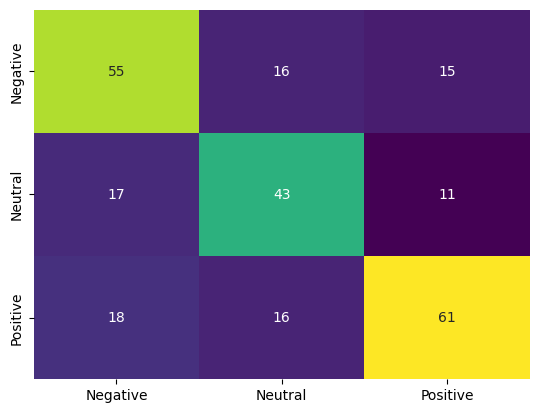

In [ ]:
svm_conf_matrix = confusion_matrix( y_test, SVM_predictions)
sns.heatmap(svm_conf_matrix, annot=True, fmt="d",cmap="viridis", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])

In [ ]:
example = "Thị trường khởi sắc sau khi thoái trào"
vector = np.array([sequencer.textToVector(example)])
result = SVM_classifier.predict(vector)
print("Sentiment: ", result[0])

Sentiment:  2


## Save Model

In [ ]:
import joblib

joblib.dump(ridge_classifier, 'ml_models/w2v_ridge_model.pkl')

joblib.dump(SVM_classifier, 'ml_models/w2v_svm_model.pkl')

['ml_models/w2v_svm_model.pkl']

In [ ]:
X_dev_vector = [sequencer.textToVector(x) for x in X_dev]

In [ ]:
ridge_model = joblib.load("ml_models/w2v_ridge_model.pkl")

ridge_predictions = ridge_model.predict(X_dev_vector)

print("Confusion Matrix:")
print(confusion_matrix(y_dev, ridge_predictions))

ridge_accuracy = accuracy_score(y_dev, ridge_predictions)
ridge_precision = precision_score(y_dev, ridge_predictions, average="weighted")
ridge_recall = recall_score(y_dev, ridge_predictions, average="weighted")
ridge_f1 = f1_score(y_dev, ridge_predictions, average="weighted")

print("Accuracy: ", ridge_accuracy)
print("Precision: ", ridge_precision)
print("Recall: ", ridge_recall)
print("F1-Score: ", ridge_f1)

Confusion Matrix:
[[58 19 16]
 [13 37 23]
 [14 21 51]]
Accuracy:  0.5793650793650794
Precision:  0.5844050751613777
Recall:  0.5793650793650794
F1-Score:  0.581194380941572


In [ ]:
svm_model = joblib.load("ml_models/w2v_svm_model.pkl")

svm_predictions = svm_model.predict(X_dev_vector)

print("Confusion Matrix:")
print(confusion_matrix(y_dev, svm_predictions))

svm_accuracy = accuracy_score(y_dev, svm_predictions)
svm_precision = precision_score(y_dev, svm_predictions, average="weighted")
svm_recall = recall_score(y_dev, svm_predictions, average="weighted")
svm_f1 = f1_score(y_dev, svm_predictions, average="weighted")

print("Accuracy: ", svm_accuracy)
print("Precision: ", svm_precision)
print("Recall: ", svm_recall)
print("F1-Score: ", svm_f1)

Confusion Matrix:
[[62 20 11]
 [12 41 20]
 [11 17 58]]
Accuracy:  0.6388888888888888
Precision:  0.6438572730542327
Recall:  0.6388888888888888
F1-Score:  0.640613552561933
